<a href="https://colab.research.google.com/github/Aditya270504/Stock-Market-Prediction-using-LSTM-XGBoost-Hybrid-Model/blob/main/Stock_Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Libraries and Modules Import**

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf

**2. Data Loading**

In [ ]:
START = "2011-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

def load_data(ticker):
  data = yf.download(ticker, START, TODAY)
  data.reset_index(inplace=True)
  return data

In [ ]:
data = load_data("RELIANCE.NS")     # Fetch historical data for the Reliance stock
df = data
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
0,2011-01-03 00:00:00+00:00,210.079269,241.292404,243.783966,240.606659,243.441086,10411256
1,2011-01-04 00:00:00+00:00,214.358063,246.206940,246.846970,241.681000,242.298172,22021878
2,2011-01-05 00:00:00+00:00,214.099380,245.909790,249.155670,244.584000,246.869827,25943243
3,2011-01-06 00:00:00+00:00,216.049652,248.149902,249.475677,245.624054,246.412659,21763180
4,2011-01-07 00:00:00+00:00,212.029602,243.532516,248.641357,241.841003,247.166992,17875107


**3. Data Preprocessing**

In [ ]:
df = df.drop(["Date", "Adj Close"], axis =1)
df.head()

<ipython-input-4-bfe0c335150f>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(["Date", "Adj Close"], axis =1)


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
0,241.292404,243.783966,240.606659,243.441086,10411256
1,246.206940,246.846970,241.681000,242.298172,22021878
2,245.909790,249.155670,244.584000,246.869827,25943243
3,248.149902,249.475677,245.624054,246.412659,21763180
4,243.532516,248.641357,241.841003,247.166992,17875107


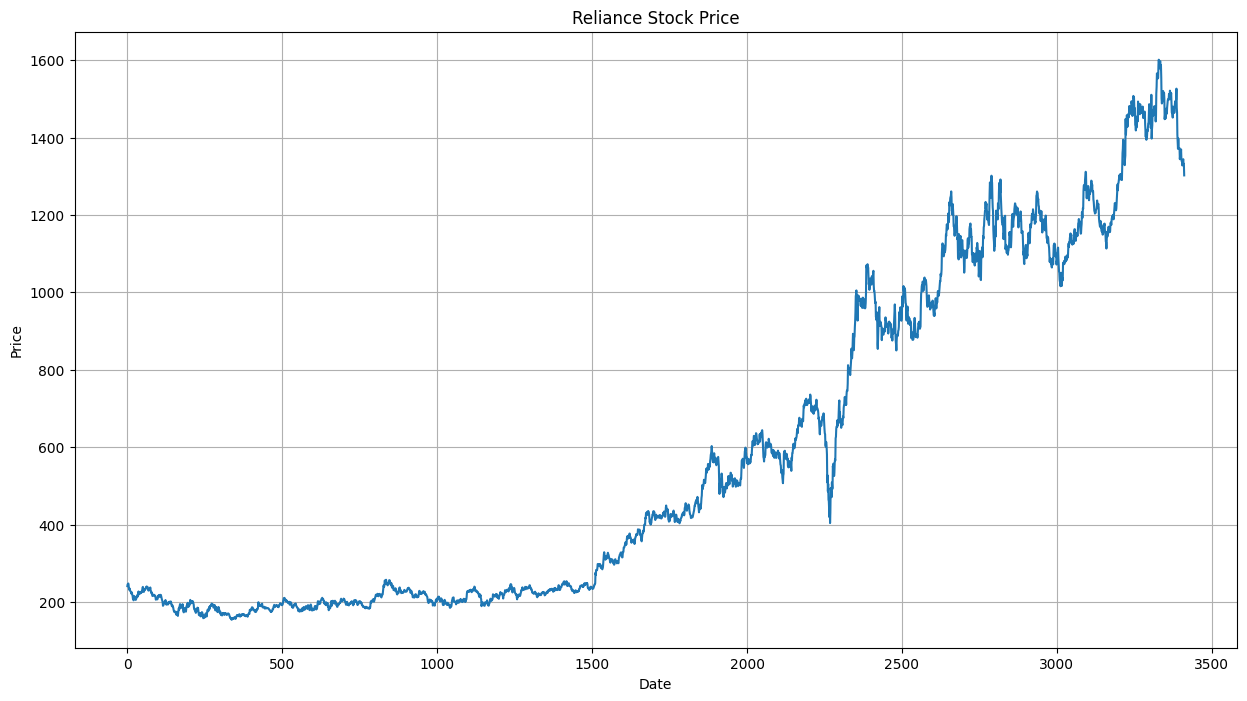

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df["Close"])
plt.title("Reliance Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

**4. Technical Analysis {Exponential Moving Averages (EMA) for 100 and 200 days}**

In [ ]:
moving_averages_100 = df["Close"].ewm(100).mean()
moving_averages_100

Ticker,RELIANCE.NS
0,241.292404
1,243.761897
2,244.484997
3,245.414944
4,245.030929
...,...
3407,1420.143102
3408,1419.388220
3409,1418.523486
3410,1417.667313


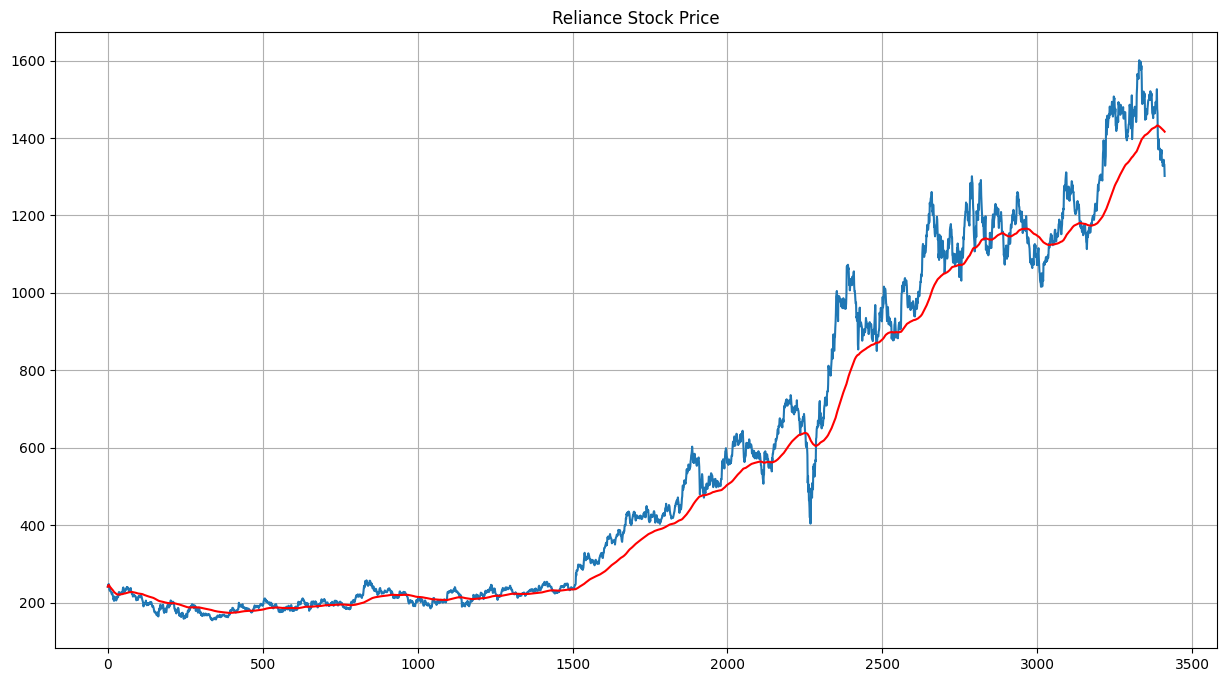

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df["Close"])
plt.plot(moving_averages_100, "red")
plt.title("Reliance Stock Price")
plt.grid(True)
plt.show()

In [ ]:
moving_averages_200 = df["Close"].ewm(200).mean()
moving_averages_200

Ticker,RELIANCE.NS
0,241.292404
1,243.755800
2,244.477381
3,245.402391
4,245.024677
...,...
3407,1348.940970
3408,1348.915891
3409,1348.831981
3410,1348.748489


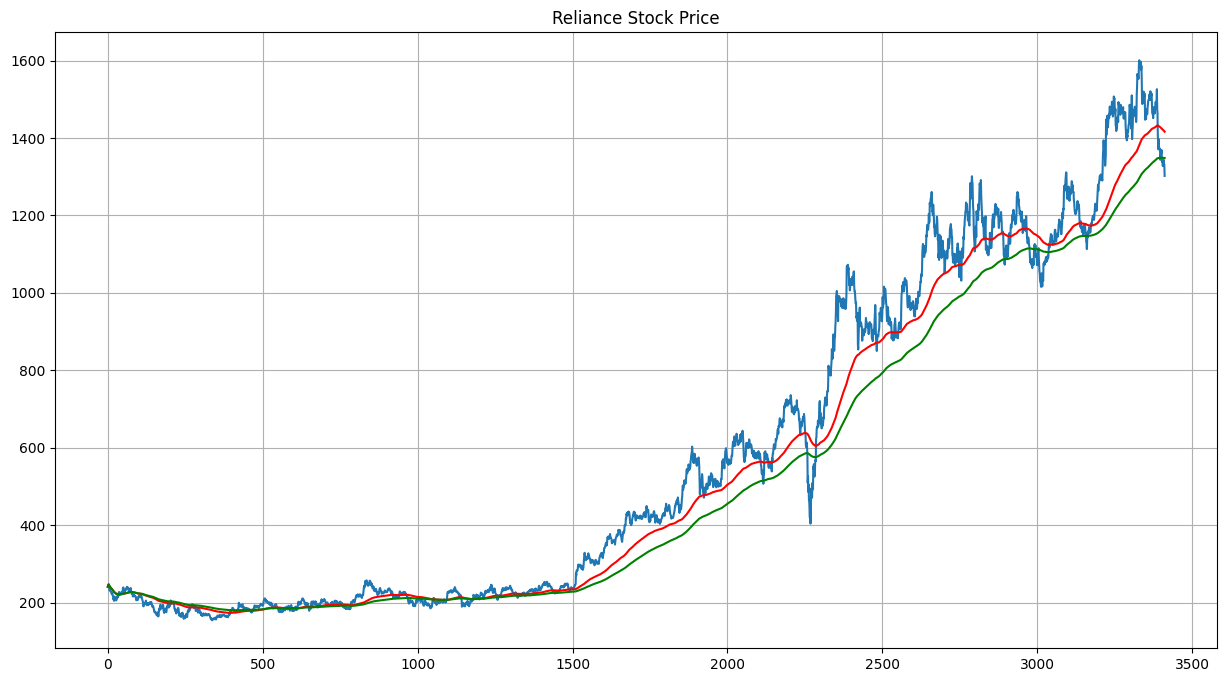

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df["Close"])
plt.plot(moving_averages_100, "red")
plt.plot(moving_averages_200, "green")
plt.title("Reliance Stock Price")
plt.grid(True)
plt.show()

In [ ]:
df.shape

(3412, 5)

**5. Data Splitting**

In [ ]:
train = pd.DataFrame(data[0:int(len(data)*0.7)])      # 70% of data for training
test = pd.DataFrame(data[int(len(data)*0.7):int(len(data))])      # Remaining 30% for testing

print(train.shape)
print(test.shape)

(2388, 7)
(1024, 7)


**6. Data Scaling**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
train_close = train.iloc[:, 2:3].values     # Using the "Close" column for training
test_close = test.iloc[:, 2:3].values

In [ ]:
data_training = scaler.fit_transform(train_close)     # Normalizing "Close" values between 0 and 1
data_training

array([[0.09470033],
       [0.10006543],
       [0.09974104],
       ...,
       [0.99710316],
       [1.        ],
       [0.99133452]])

**7. LSTM Model Development**

In [ ]:
x_train_lstm = []
y_train_lstm = []

for i in range(100, data_training.shape[0]):
  x_train_lstm.append(data_training[i-100:i])     # Use the past 100 days as input features
  y_train_lstm.append(data_training[i, 0])      # Predict the 101st day's closing price

x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [ ]:
x_train_lstm.shape

(2288, 100, 1)

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Input(shape=(x_train_lstm.shape[1], 1)))

model.add(LSTM(units = 50, activation = 'relu', return_sequences=True))
model.add(Dropout(0.2))     # Prevent overfitting by randomly dropping 20% of connections


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))     # Output layer with 1 neuron to predict a single value

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train_lstm, y_train_lstm,epochs=10)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 307ms/step - loss: 0.0322 - mean_absolute_error: 0.1216
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 309ms/step - loss: 0.0035 - mean_absolute_error: 0.0375
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 294ms/step - loss: 0.0027 - mean_absolute_error: 0.0304
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 348ms/step - loss: 0.0027 - mean_absolute_error: 0.0307
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 291ms/step - loss: 0.0023 - mean_absolute_error: 0.0290
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 300ms/step - loss: 0.0028 - mean_absolute_error: 0.0312
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 320ms/step - loss: 0.0026 - mean_absolute_error: 0.0302
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - loss: 0.0025 - mean_absolute_error: 0.0295
Epoch 9/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0027 - mean_absolute_error: 0.0321
Epoch 10/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - loss: 0.0028 - mean_absolute_error: 0.0332


In [ ]:
model.save("StockMarket.keras")

**8. Testing LSTM Predictions**

In [ ]:
test_close.shape

(1024, 1)

In [ ]:
past_100days = pd.DataFrame(train_close[-100:])     # Include the last 100 days of training data

In [ ]:
test_data = pd.DataFrame(test_close)

In [ ]:
testing_df = pd.concat([past_100days, test_data], ignore_index=True)
testing_df

,0
0,647.804749
1,653.633606
2,652.902161
3,652.353516
4,670.205872
...,...
1119,1340.000000
1120,1343.900024
1121,1332.050049
1122,1332.050049


In [ ]:
data_testing = scaler.fit_transform(testing_df)
data_testing

array([[0.        ],
       [0.00611571],
       [0.00534827],
       ...,
       [0.7179191 ],
       [0.7179191 ],
       [0.6865476 ]])

In [ ]:
x_test_lstm = []
y_test_lstm = []

for i in range(100, data_testing.shape[0]):
  x_test_lstm.append(data_testing[i-100:i])
  y_test_lstm.append(data_testing[i, 0])

x_test_lstm, y_test_lstm = np.array(x_test_lstm), np.array(y_test_lstm)

In [ ]:
print(x_test_lstm.shape)
print(y_test_lstm.shape)

(1024, 100, 1)
(1024,)


In [ ]:
y_pred = model.predict(x_test_lstm)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step


In [ ]:
y_pred.shape
y_pred

array([[0.33431476],
       [0.3369078 ],
       [0.34047306],
       ...,
       [0.7338564 ],
       [0.7288754 ],
       [0.7242929 ]], dtype=float32)

In [ ]:
y_pred1 = scaler.inverse_transform(y_pred)
y_test_reshape = y_test_lstm.reshape(-1,1)
y_test1 = scaler.inverse_transform(y_test_reshape)

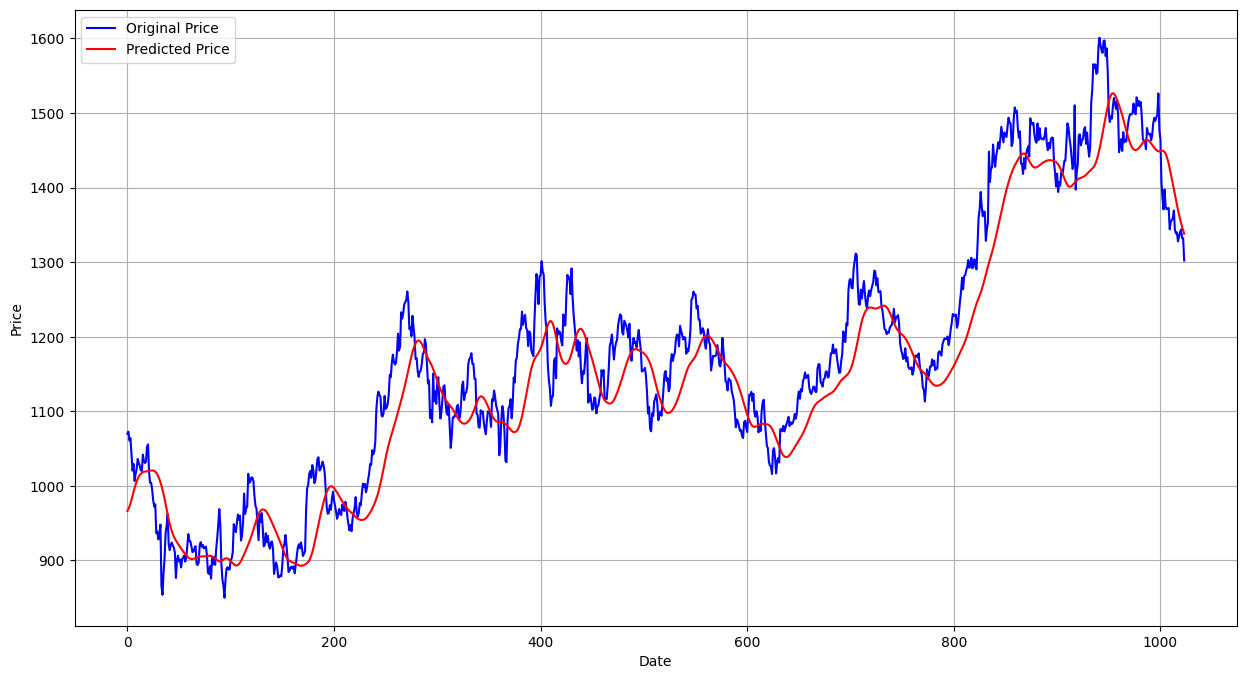

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(y_test1, "blue", label="Original Price")
plt.plot(y_pred1, "red", label="Predicted Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

**9. Evaluation (LSTM Model)**

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_lstm, y_pred)
mae_percentage = (mae / np.mean(y_test_lstm)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 8.33%


**10. Residual Correction Using XGBoost**

In [ ]:
LSTM_predictions = np.array(y_pred).flatten()
actual_values = np.array(y_test_lstm)

residuals = actual_values - LSTM_predictions

x = LSTM_predictions.reshape(-1, 1)
y = residuals.reshape(-1, 1)

In [ ]:
split_index = int(0.7 * len(x))

x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=10, learning_rate=0.01, max_depth=5)
xgb_model.fit(x_train, y_train)     # Train XGBoost on residuals from LSTM predictions

predicted_residuals = xgb_model.predict(x_test)
final_predictions_test = x_test.flatten() + predicted_residuals     # Add residual corrections to LSTM predictions

In [ ]:
y_pred_reshape_xgb = final_predictions_test.reshape(-1,1)
y_pred2 = scaler.inverse_transform(y_pred_reshape_xgb)
y_test_reshape_xgb = actual_values[len(actual_values) - len(final_predictions_test):].reshape(-1,1)
y_test2 = scaler.inverse_transform(y_test_reshape_xgb)

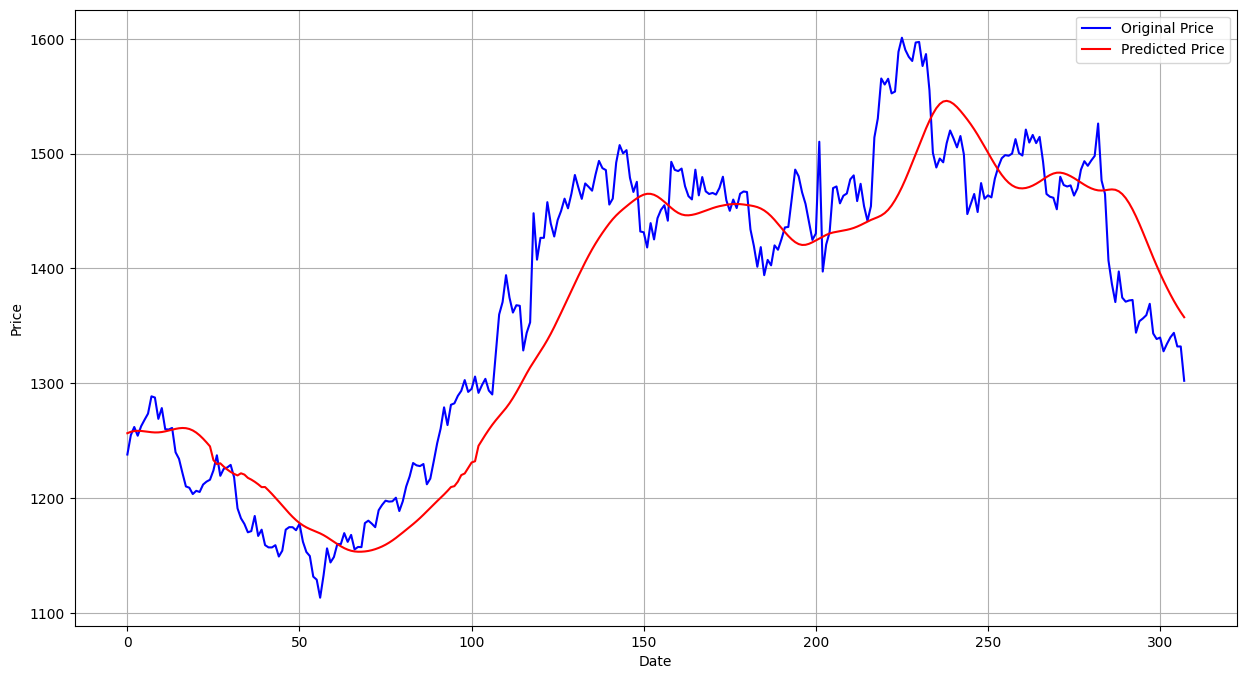

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(y_test2, "blue", label="Original Price")
plt.plot(y_pred2, "red", label="Predicted Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

**11. Evaluation (XGBoost)**

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_xgb = mean_absolute_error(actual_values[len(actual_values) - len(final_predictions_test):], final_predictions_test)
mae_percentage_xgb = (mae_xgb / np.mean(actual_values[len(actual_values) - len(final_predictions_test):])) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage_xgb))

Mean absolute error on test set: 5.62%
